<a href="https://colab.research.google.com/github/kanalive/notebooks/blob/main/chatwithmysqldata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Your API Key


In [1]:
import json
# Load environment object from JSON
file_path = '/content/drive/MyDrive/keys/keys.json'  # Replace with the actual file path
with open(file_path, 'r') as file:
    loaded_object = json.load(file)

OPEN_AI_API_KEY = loaded_object['OPEN_AI_API_KEY']

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Your Configuration

In [57]:
project = 'forexexample' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
big_query_job_id = 'bquxjob_26d65cc1_188d1aa3f36' #execute a query on Big Query, get the ID from the Job Information tab

# Setup

In [4]:
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

In [58]:
job = client.get_job(big_query_job_id) # Job ID inserted based on the query results selected to explore
print(job.query)

SELECT * FROM `forexexample.forex_dataset.usd_aud` order by Date


# Data preview

In [59]:
job = client.get_job(big_query_job_id) # Job ID inserted based on the query results selected to explore
results = job.to_dataframe()

In [60]:
results

,Date,USD_AUD
0,1971-01-01,1.1181
1,1971-02-01,1.1238
2,1971-03-01,1.1243
3,1971-04-01,1.1238
4,1971-05-01,1.1243
...,...,...
623,2022-12-01,0.6748
624,2023-01-01,0.6955
625,2023-02-01,0.6893
626,2023-03-01,0.6676


In [61]:
pd.to_datetime(results['Date'])


0     1971-01-01
1     1971-02-01
2     1971-03-01
3     1971-04-01
4     1971-05-01
         ...    
623   2022-12-01
624   2023-01-01
625   2023-02-01
626   2023-03-01
627   2023-04-01
Name: Date, Length: 628, dtype: datetime64[ns]

# Setup OpenAI API and Langchain

In [62]:
!pip install openai -q
!pip install langchain -q
import os
os.environ["OPENAI_API_KEY"] = OPEN_AI_API_KEY
from langchain.agents import create_sql_agent
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from langchain.sql_database import SQLDatabase
from langchain.llms.openai import OpenAI
from langchain.agents import AgentExecutor

In [63]:
from langchain.agents.agent_toolkits.pandas.base import create_pandas_dataframe_agent
agent = create_pandas_dataframe_agent(OpenAI(temperature=0), results, verbose=True)

In [64]:
agent.run("Describe the table")



> Entering new  chain...
Thought: I need to look at the table and understand what it is showing
Action: python_repl_ast
Action Input: print(df.head())
Observation:          Date  USD_AUD
0  1971-01-01   1.1181
1  1971-02-01   1.1238
2  1971-03-01   1.1243
3  1971-04-01   1.1238
4  1971-05-01   1.1243

Thought: I can see that the table contains two columns, Date and USD_AUD
Final Answer: The table contains two columns, Date and USD_AUD, which show the date and the exchange rate between US Dollars and Australian Dollars, respectively.

> Finished chain.


'The table contains two columns, Date and USD_AUD, which show the date and the exchange rate between US Dollars and Australian Dollars, respectively.'

In [13]:
# data = "\n".join([f"{x[1]} {x[2]}" for x in results])
# import datetime as dt

# d_x_now = results[results["Date"] > pd.Timestamp(dt.datetime.now() - dt.timedelta(days=365))]

# json_obj = d_x_now.to_json(orient='records', date_format='iso')
# agent.run(f"Please predict the USD to AUD in 2023 May using this dataset.\n{json_obj}")

# Agent run tasks

In [67]:
agent.run("When was the AUD to USD the lowest, please give me the date and the rate")



> Entering new  chain...
Thought: I need to find the lowest value in the USD_AUD column
Action: python_repl_ast
Action Input: df['USD_AUD'].min()
Observation: 0.5016
Thought: I need to find the row with the lowest value
Action: python_repl_ast
Action Input: df.loc[df['USD_AUD'] == df['USD_AUD'].min()]
Observation:            Date  USD_AUD
363  2001-04-01   0.5016
Thought: I now know the final answer
Final Answer: The AUD to USD was lowest on April 1, 2001 at 0.5016.

> Finished chain.


'The AUD to USD was lowest on April 1, 2001 at 0.5016.'

In [69]:
agent.run("what's the percentage of change of the USD to AUD from 2020 Janurary to 2023 April")



> Entering new  chain...
Thought: I need to find the USD_AUD value for both dates
Action: python_repl_ast
Action Input: df[df['Date'] == '2020-01-01']['USD_AUD'].values[0]
Observation: IndexError: index 0 is out of bounds for axis 0 with size 0
Thought: I need to make sure the date is in the dataframe
Action: python_repl_ast
Action Input: df[df['Date'] == '2020-01-01'].shape[0]
Observation: 0
Thought: The date is not in the dataframe
Action: python_repl_ast
Action Input: df[df['Date'] == '2023-04-01']['USD_AUD'].values[0]
Observation: IndexError: index 0 is out of bounds for axis 0 with size 0
Thought: I need to make sure the date is in the dataframe
Action: python_repl_ast
Action Input: df[df['Date'] == '2023-04-01'].shape[0]
Observation: 0
Thought: The date is not in the dataframe
Final Answer: The percentage of change of the USD to AUD from 2020 Janurary to 2023 April cannot be calculated because the dates are not in the dataframe.

> Finished chain.


'The percentage of change of the USD to AUD from 2020 Janurary to 2023 April cannot be calculated because the dates are not in the dataframe.'

In [70]:
results[results['Date'] == '2022-01-01']

,Date,USD_AUD




> Entering new  chain...
Thought: I need to filter the dataframe to get the data from 2020 to 2023
Action: python_repl_ast
Action Input: df[(df['Date'] >= '2020-01-01') & (df['Date'] <= '2023-12-31')]
Observation: TypeError: '>=' not supported between instances of 'DateArray' and 'str'
Thought: I need to convert the date to a string
Action: python_repl_ast
Action Input: df[(df['Date'].astype(str) >= '2020-01-01') & (df['Date'].astype(str) <= '2023-12-31')]
Observation:            Date  USD_AUD
588  2020-01-01   0.6851
589  2020-02-01   0.6664
590  2020-03-01   0.6218
591  2020-04-01   0.6312
592  2020-05-01   0.6517
593  2020-06-01   0.6899
594  2020-07-01   0.7040
595  2020-08-01   0.7203
596  2020-09-01   0.7224
597  2020-10-01   0.7121
598  2020-11-01   0.7270
599  2020-12-01   0.7532
600  2021-01-01   0.7726
601  2021-02-01   0.7753
602  2021-03-01   0.7710
603  2021-04-01   0.7701
604  2021-05-01   0.7763
605  2021-06-01   0.7643
606  2021-07-01   0.7417
607  2021-08-01   0.7304

"Use the python_repl_ast tool to execute the command `df[(df['Date'].astype(str) >= '2020-01-01') & (df['Date'].astype(str) <= '2023-12-31')].plot(x='Date', y='USD_AUD', color='orange', figsize=(20,10))` to plot a chart showing the AUD to USD trend from 2020 to 2023 with the line in orange and the chart size twice as big."

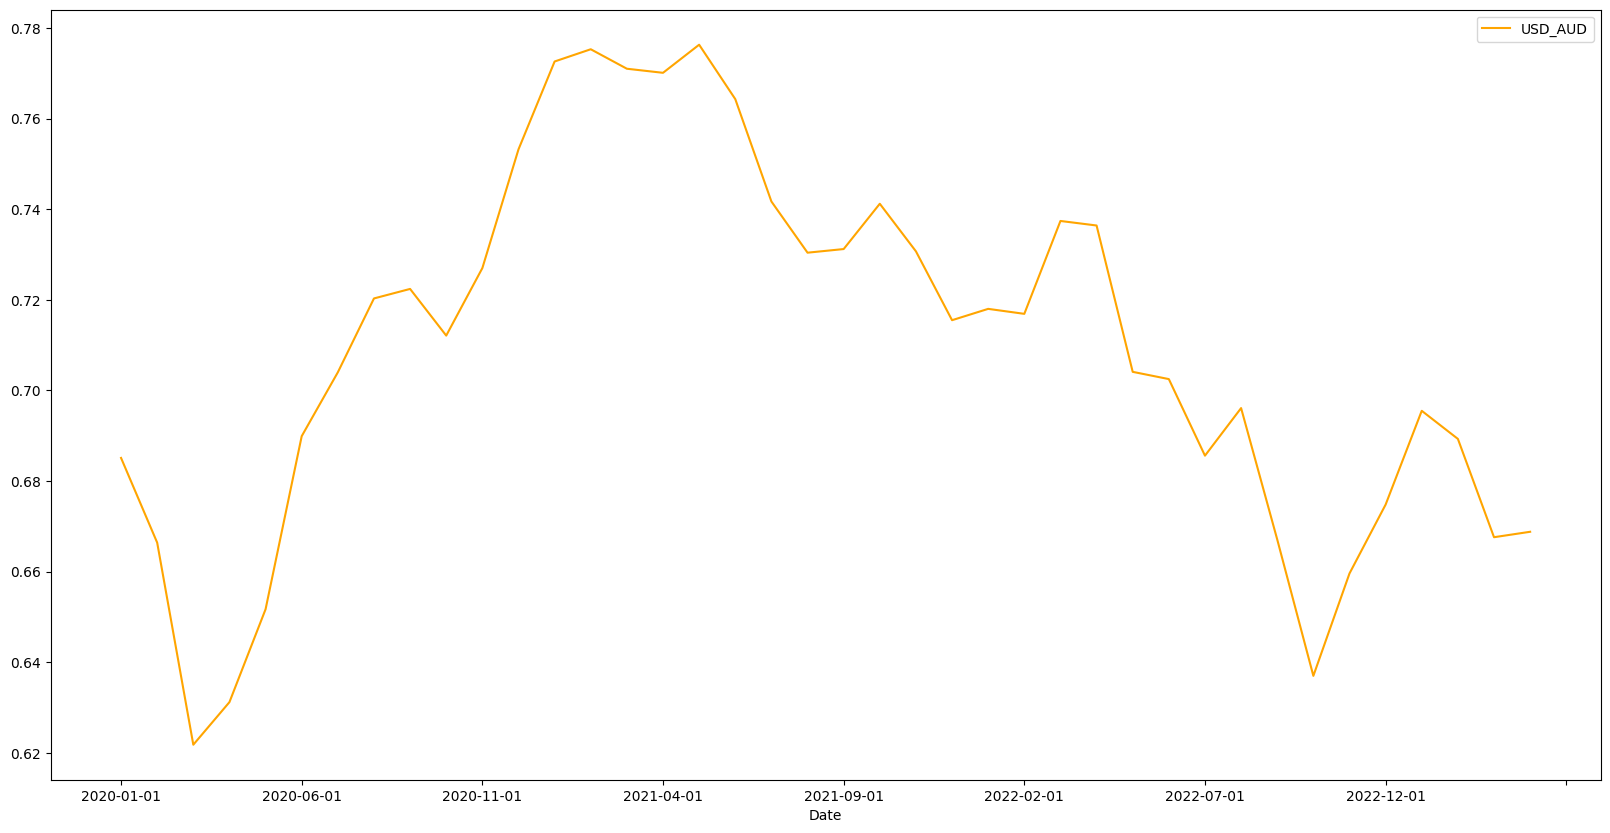

In [72]:
agent.run("can you plot a chart to show me the AUD to USD trend from 2020 to 2023.please make the chart line in orange, make the chart size twice big")

In [ ]:
agent.run("If I always trade EUR to USD in 1 month window, in the past 2 years, what was the best timing to buy in and sell so that I can profit the most. profit means the sell price minus the buy in price")



> Entering new AgentExecutor chain...
Thought: I need to find the highest difference between the buy in and sell price
Action: python_repl_ast
Action Input: df['EUR_USD'].diff().max()
Observation: 42.15089999999999
Thought: I now know the highest difference between the buy in and sell price
Final Answer: The highest difference between the buy in and sell price in the past 2 years is 42.15089999999999.

> Finished chain.


'The highest difference between the buy in and sell price in the past 2 years is 42.15089999999999.'

In [ ]:
agent.run("find the higest difference between buy in and sell price in the past 2 years, and give me the dates of the buy in and sell")



> Entering new AgentExecutor chain...
Thought: I need to find the highest difference between two prices in the past two years
Action: python_repl_ast
Action Input: df[df['Date'] > '2018-01-01'].sort_values('EUR_USD', ascending=False)
Observation:            Date   EUR_USD
870  2019-09-03  131.8808
172  2019-09-02  131.6829
171  2019-08-30  131.6829
622  2019-08-29  131.5680
5790 2019-10-02  131.4631
...         ...       ...
2513 2018-02-02  115.8271
6148 2018-01-31  115.4529
4457 2018-01-26  115.3967
1764 2018-01-25  115.2149
2920 2018-02-01  115.1867

[521 rows x 2 columns]
Thought: I need to find the difference between the highest and lowest value
Action: python_repl_ast
Action Input: df[df['Date'] > '2018-01-01']['EUR_USD'].max() - df[df['Date'] > '2018-01-01']['EUR_USD'].min()
Observation: 16.69409999999999
Thought: I need to find the dates of the buy in and sell
Action: python_repl_ast
Action Input: df[df['EUR_USD'] == df[df['Date'] > '2018-01-01']['EUR_USD'].max()]
Observation

'The highest difference between buy in and sell price in the past 2 years is 16.694, with the buy in date being 2019-09-03 and the sell date being 2018-02-01.'

In [73]:
agent.run("add another column named Change in results dataframe")



> Entering new  chain...
Thought: I need to calculate the difference between each row
Action: python_repl_ast
Action Input: df['Change'] = df['USD_AUD'].diff()
Observation: 
Thought: I now know the final answer
Final Answer: df['Change'] = df['USD_AUD'].diff()

> Finished chain.


"df['Change'] = df['USD_AUD'].diff()"

In [76]:
results

,Date,USD_AUD,Change
0,1971-01-01,1.1181,NaN
1,1971-02-01,1.1238,0.0057
2,1971-03-01,1.1243,0.0005
3,1971-04-01,1.1238,-0.0005
4,1971-05-01,1.1243,0.0005
...,...,...,...
623,2022-12-01,0.6748,0.0152
624,2023-01-01,0.6955,0.0207
625,2023-02-01,0.6893,-0.0062
626,2023-03-01,0.6676,-0.0217




> Entering new  chain...
Thought: I need to calculate the USD_AUD change first
Action: python_repl_ast
Action Input: df['USD_AUD_Change'] = df['USD_AUD'].diff()
Observation: 
Thought: I need to plot the chart
Action: python_repl_ast
Action Input: df.plot(x='Date', y='USD_AUD_Change', figsize=(20, 10))
Observation: Axes(0.125,0.11;0.775x0.77)
Thought: I now know the final answer
Final Answer: The chart is plotted with x axis showing Dates, y axis showing the USD_AUD change, the USD_AUD change is calculated by the current row of USD_AUD value - the previous row of USD_AUD value, and the chart size is double of the default size.

> Finished chain.


'The chart is plotted with x axis showing Dates, y axis showing the USD_AUD change, the USD_AUD change is calculated by the current row of USD_AUD value - the previous row of USD_AUD value, and the chart size is double of the default size.'

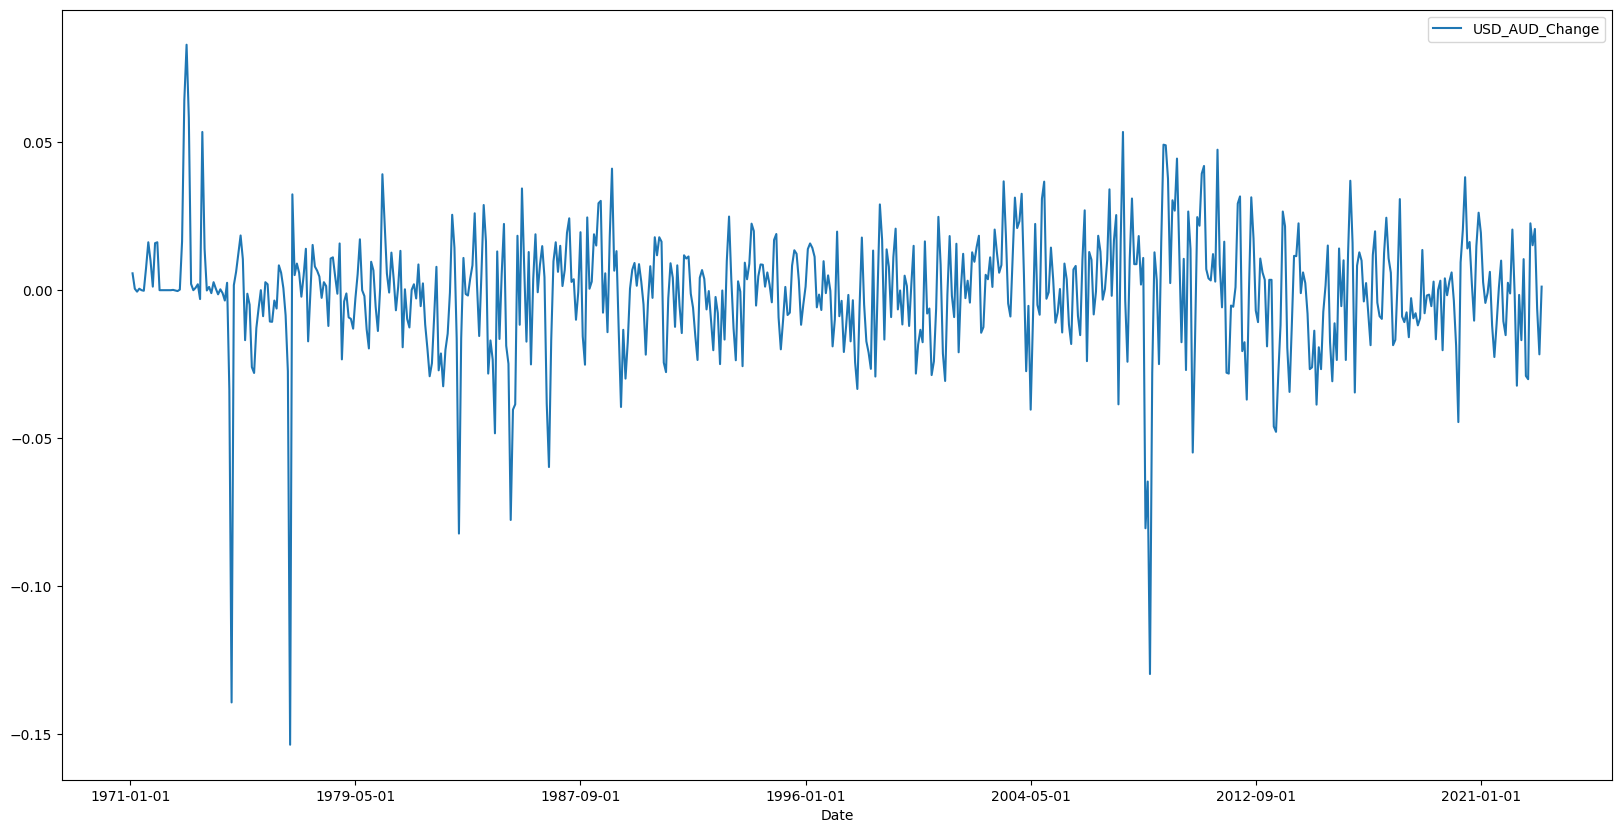

In [77]:

agent.run("Please plot a chart, x axis showing Dates, y axis showing the USD_AUD change, the USD_AUD change should be calculated by the current row of USD_AUD value - the previous row of USD_AUD value. Please also make the chart size double of the default size")

In [ ]:
results['USD_AUD_change'] = results['USD_AUD'].diff()

In [ ]:
results

,Date,USD_AUD,USD_AUD_Change,USD_AUD_change
0,1995-01-04,94.3497,NaN,NaN
1,1995-01-05,94.0717,-0.2780,-0.2780
2,1995-01-06,94.3577,0.2860,0.2860
3,1995-01-09,94.3348,-0.0229,-0.0229
4,1995-01-10,94.5032,0.1684,0.1684
...,...,...,...,...
6515,2019-12-25,129.1831,0.0000,0.0000
6516,2019-12-26,129.0163,-0.1668,-0.1668
6517,2019-12-27,128.6101,-0.4062,-0.4062
6518,2019-12-30,128.3353,-0.2748,-0.2748
